# Clasificación de estado de presión de llantas vehículos a partir de imágenes

###Juan Nicolás Soto Rios
###Katherine Xiomar González Santacruz
###Frank M. Córdoba O.


# 1. Cargando Archivos

In [ ]:
import os
os.getcwd()
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
flat_class = []
for image in os.listdir('flat.class'):
  flat_class.append(cv2.imread(os.path.join('flat.class', image)))

In [ ]:
full_class = []
for image in os.listdir('full.class'):
  full_class.append(cv2.imread(os.path.join('full.class', image)))

In [ ]:
cv2_imshow(flat_class[0]), cv2_imshow(full_class[0]) 

In [ ]:
print(flat_class[0].shape)
print(len(flat_class))

print(full_class[0].shape)
print(len(full_class))

In [ ]:
flat_gray = []
full_gray = []
full_data = []
for img in flat_class:
  flat_gray.append(np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)).flatten())
  full_data.append(np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)).flatten())
for img in full_class:
  full_gray.append(np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)).flatten())
  full_data.append(np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)).flatten())

flat_gray = np.array(flat_gray)
full_gray = np.array(full_gray)
full_data = np.array(full_data)

In [ ]:
print(flat_gray.shape)
print(len(flat_gray))

print(full_gray.shape)
print(len(full_gray))

print(full_data.shape)
print(len(full_data))

In [ ]:
etiquetas = np.zeros((300,))
etiquetas = np.append(etiquetas, np.ones((300,)))
etiquetas.shape

# 2. Analizar dimensionalidad de los datos

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)

pca.fit(full_data)

In [ ]:
print(pca.explained_variance_ratio_[:5])
print(pca.explained_variance_ratio_.sum())

In [ ]:
# Plot
c = []
v_ac = []
v_i = 0
for v in pca.explained_variance_ratio_:
  v_i += v
  v_ac.append(v_i) 
plt.plot(range(len(pca.explained_variance_ratio_)), v_ac)
plt.ylabel('Varianza Explicada')
plt.xlabel('Componentes Principales')
plt.title('Varianza Explicada Acumulada')
plt.show()

In [ ]:
n_c = 0
i = 0
counting = True
while counting:
  n_c += pca.explained_variance_ratio_[i]
  i += 1
  if n_c >= 0.8:
    print(f'Numero de variables: {i}')
    counting = False
  

In [ ]:
pca = PCA(3) 
projected = pca.fit_transform(full_data)

plt.scatter(projected[:, 0], projected[:, 1],
            c=etiquetas, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('viridis', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [ ]:
import plotly.express as px
fig = px.scatter_3d( x= projected[:, 0], y= projected[:, 1], z= projected[:, 2],
              color= etiquetas, )
fig.show()

In [ ]:
pca = PCA(70)

X = pca.fit_transform(full_data)
y = etiquetas

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test_p, y_train, y_test_p = train_test_split(X, y, test_size=0.3, random_state=42)


print(X_train.shape)
print(X_test_p.shape)
print(y_train.shape)
print(y_test_p.shape)

# 3. Red Neuronal

## 3.1 Modelo Red Neuronal 1

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

X_val, X_test, y_val, y_test = train_test_split(X_test_p, y_test_p, test_size= 0.3, random_state= 42)

validation = True

n_features = X_train.shape[1]
# Definicion del modelo
nn_model = Sequential()
nn_model.add(Dense(128, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
nn_model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
nn_model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
nn_model.add(Dense(1, activation='sigmoid'))

# Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Compilacion del modelo
nn_model.compile(optimizer='adam', loss= tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
start = time.time()

# fit
if validation: 
  nn_model.fit(X_train, y_train, epochs=20, batch_size=10,  callbacks=[callback],  validation_data = (X_val, y_val))
else:
   nn_model.fit(X_train, y_train, epochs=20, batch_size=10,  callbacks=[callback],  validation_data = None)
# evaluacion
if validation:
  # train accuracy
  loss, acc = nn_model.evaluate(X_train, y_train, verbose=0)
  print('Train Accuracy: %.3f' % acc)
  # test acccuracy
  loss, acc = nn_model.evaluate(X_test, y_test, verbose=0)
  print('Test Accuracy: %.3f' % acc)
else:
  # train accuracy
  loss, acc = nn_model.evaluate(X_train, y_train, verbose=0)
  print('Train Accuracy: %.3f' % acc)
  # test acccuracy
  loss, acc = nn_model.evaluate(X_test_p, y_test_p, verbose=0)
  print('Test Accuracy: %.3f' % acc)

end = time.time()
t_total = (end-start)/60
print(f'Tiempo de entrenamiento: {t_total} minutos')

In [ ]:
# Diagrama del modelo
from keras.utils.vis_utils import plot_model
plot_model(nn_model,  show_shapes=True, show_layer_names=True)

In [ ]:
# Predicciones
y_pred_nn = nn_model.predict(X_test_p)
y_pred_nn = np.array(y_pred_nn).flatten()
y_pred_nn = (y_pred_nn > 0.9).astype(int)
print(classification_report(y_test_p, y_pred_nn))

In [ ]:
# Matriz de confusion
cm = confusion_matrix(y_test_p, y_pred_nn)
print(cm)

In [ ]:
# Matriz de confusion
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels= None)


disp = disp.plot(include_values= True, cmap='viridis')

plt.show()

## 3.2 Modelo Red Neuronal 2

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


validation = True

n_features = X_train.shape[1]
# Definicion del modelo
nn_model = Sequential()
nn_model.add(Dense(254, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
nn_model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
nn_model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
nn_model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
nn_model.add(Dense(1, activation='sigmoid'))

# Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Compilacion del modelo
nn_model.compile(optimizer='adam', loss= tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
start = time.time()
# fit
if validation: 
  nn_model.fit(X_train, y_train, epochs=20, batch_size=10,  callbacks=[callback],  validation_data = (X_val, y_val))
else:
   nn_model.fit(X_train, y_train, epochs=20, batch_size=10,  callbacks=[callback],  validation_data = None)
# evaluacion
if validation:
  # train accuracy
  loss, acc = nn_model.evaluate(X_train, y_train, verbose=0)
  print('Train Accuracy: %.3f' % acc)
  # test acccuracy
  loss, acc = nn_model.evaluate(X_test, y_test, verbose=0)
  print('Test Accuracy: %.3f' % acc)
else:
  # train accuracy
  loss, acc = nn_model.evaluate(X_train, y_train, verbose=0)
  print('Train Accuracy: %.3f' % acc)
  # test acccuracy
  loss, acc = nn_model.evaluate(X_test_p, y_test_p, verbose=0)
  print('Test Accuracy: %.3f' % acc)
end = time.time()
t_total = (end-start)/60
print(f'Tiempo de entrenamiento: {t_total} minutos')

In [ ]:
# Diagrama del modelo
from keras.utils.vis_utils import plot_model
plot_model(nn_model,  show_shapes=True, show_layer_names=True)

In [ ]:
# Predicciones
y_pred_nn = nn_model.predict(X_test_p)
y_pred_nn = np.array(y_pred_nn).flatten()
y_pred_nn = (y_pred_nn > 0.9).astype(int)
print(classification_report(y_test_p, y_pred_nn))

In [ ]:
# Matriz de confusion
cm = confusion_matrix(y_test_p, y_pred_nn)
print(cm)

In [ ]:
# Matriz de confusion
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels= None)


disp = disp.plot(include_values= True, cmap='viridis')

plt.show()

# 4. Redes Convolucionales

## 4.1 Preparacion de Imagenes

In [ ]:
full_data_2 = []
for img in flat_class:
  full_data_2.append(np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))

for img in full_class:
  full_data_2.append(np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))

In [ ]:
## Particion de la base de datos en train - test
from sklearn.model_selection import train_test_split
X_train_i, X_test_p_i, y_train_i, y_test_p_i = train_test_split(np.array(full_data_2), etiquetas, test_size=0.3, random_state=42)


print(X_train_i.shape)
print(X_test_p_i.shape)
print(y_train_i.shape)
print(y_test_p_i.shape)

In [ ]:
# Particion de datos para validacion y test
X_val, X_test, y_val, y_test = train_test_split(X_test_p_i, y_test_p_i, test_size=0.3, random_state=42)

## 4.1 Modelo Red Convolucional 1

In [ ]:
# Definicion del modelo
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding= "same" , input_shape=(240, 240,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding= "same", activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding= "same", activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [ ]:
# Resumen del modelo
model.summary()

In [ ]:
# Diagrama del modelo
from keras.utils.vis_utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)

In [ ]:
# Se establece Callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

In [ ]:
# Entrenamiento
start = time.time()
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train_i, y_train_i, epochs=10, 
                    validation_data=(X_val, y_val), batch_size =32, callbacks = [callback])
end = time.time()
t_total = (end-start)/60
print(f'Tiempo de entrenamiento: {t_total} minutos')

In [ ]:
# Historico de metricas durante entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
print(test_acc)

In [ ]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, plot_confusion_matrix
y_pred = model.predict(X_test)
y_pred= np.array(y_pred).flatten()
y_pred_nn = (y_pred> 0.9).astype(int)
print(classification_report(y_test, y_pred_nn))

In [ ]:
# Matriz de confusion
cm = confusion_matrix(y_test, y_pred_nn)
print(cm)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels= None)


disp = disp.plot(include_values= True, cmap='viridis')

plt.show()

## 4.3 Modelo Red Convolucional 2

In [ ]:
# Definicion del modelo
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding= "same" , input_shape=(240, 240,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding= "same", activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding= "same", activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding= "same", activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

In [ ]:
# Resumen del modelo
model.summary()

In [ ]:
# Diagrama del modelo
from keras.utils.vis_utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)

In [ ]:
# Se establece Callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

In [ ]:
# Entrenamiento
start = time.time()
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train_i, y_train_i, epochs=10, 
                    validation_data=(X_val, y_val), batch_size =32, callbacks = [callback])
end = time.time()
t_total = (end-start)/60
print(f'Tiempo de entrenamiento: {t_total} minutos')

In [ ]:
# Historico de metricas durante entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, plot_confusion_matrix
y_pred = model.predict(X_test)
y_pred= np.array(y_pred).flatten()
y_pred_nn = (y_pred> 0.9).astype(int)
print(classification_report(y_test, y_pred_nn))

In [ ]:
# Matriz de confusion
cm = confusion_matrix(y_test, y_pred_nn)
print(cm)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels= None)


disp = disp.plot(include_values= True, cmap='viridis')

plt.show()

# 5. Algoritmos Genéticos

## 5.1. Planteamiento inicial

In [ ]:
from sklearn.model_selection import train_test_split
!pip install pygad>=2.8.0
!pip install sklearn-genetic
import pygad
print(pygad.__version__)

In [ ]:
import random
import numpy as np
from sklearn import linear_model
from genetic_selection import GeneticSelectionCV

# When using multiple processes (n_jobs != 1), protect the entry point of the program if necessary

estimator = linear_model.LogisticRegression(solver="liblinear", multi_class="ovr")

selector = GeneticSelectionCV(
    estimator,
    cv=5,
    verbose=1,
    scoring="accuracy",
    max_features=5,
    n_population=int(0.2*X_train.shape[0]),
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=40,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.05,
    tournament_size=3,
    n_gen_no_change=10,
    caching=True,
    n_jobs=-1,
)
selector = selector.fit(X_train, y_train)

print(selector.support_)

In [ ]:
preds = selector.predict(X_test_p)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
print(classification_report(y_test_p, preds))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels= None)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(include_values= True, cmap='viridis')

plt.show()

##5.2 Busqueda de parametros externos

In [ ]:
# Buscando mejores parametros
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import time
log_reg = linear_model.LogisticRegression(solver="liblinear", multi_class="ovr")
k_n = KNeighborsClassifier(n_neighbors = 10)

pca_f = [50, 70, 100]
estimators = [log_reg, k_n]
estimators_names = ['Regresion Logistica', 'K_nearest']
population_i = [0.1, 0.2, 0.3, 0.4]
generation_n = [20, 40 ,60]
Acc = []
t = []
resume = []

In [ ]:
res_p = []
res_e = []
res_np = []
res_ng = []
res_acc = []
res_roc = []
res_t = []
res_pca_t = []
selectors = []

In [ ]:
def run_gen(estimator, pop_i, gen, total_pop):
  selector = GeneticSelectionCV(
      estimator,
      cv=5,
      verbose=0,
      scoring="accuracy",
      max_features=5,
      n_population=int(pop_i*total_pop),
      crossover_proba=0.5,
      mutation_proba=0.2,
      n_generations=gen,
      crossover_independent_proba=0.5,
      mutation_independent_proba=0.05,
      tournament_size=3,
      n_gen_no_change=10,
      caching=True,
      n_jobs=-1,
  )
  return selector

def feature_extraction(pca_n, data):
  pca = PCA(pca_n)

  X = pca.fit_transform(data)
  y = etiquetas

  X_train, X_test_p, y_train, y_test_p = train_test_split(X, y, test_size=0.3, random_state=42)

  return X_train, X_test_p, y_train, y_test_p

In [ ]:
for p_n in pca_f:
  start_p = time.time()
  X_train, X_test_p, y_train, y_test_p = feature_extraction(p_n, full_data)
  end_p = time.time()
  t_p = end_p - start_p
  for i, estimator in enumerate(estimators):
    for pop_i in population_i:
      for gen in generation_n:
        print(f'N_car: {p_n} --- Estimador: {estimators_names[i]} --- Poblacion_i: {pop_i} --- Generaciones: {gen}')
        start = time.time()
        selector = run_gen(estimator, pop_i, gen, total_pop = X_train.shape[0])
        selector.fit(X_train, y_train)
        end = time.time()
        t = end - start
        preds = selector.predict(X_test_p)
        acc = accuracy_score(y_test_p, preds)
        roc = roc_auc_score(y_test_p, preds)
        print(f'tiempo de ejecucion: {t} --- Acc: {acc}')
        res_p.append(p_n)
        res_e.append(estimators_names[i])
        res_np.append(pop_i)
        res_ng.append(gen)
        res_acc.append(acc)
        res_roc.append(roc)
        res_t.append(t)
        res_pca_t.append(t_p)
        selectors.append(selector)
        

N_car: 50 --- Estimador: Regresion Logistica --- Poblacion_i: 0.1 --- Generaciones: 20
tiempo de ejecucion: 3.2313146591186523 --- Acc: 0.8277777777777777
N_car: 50 --- Estimador: Regresion Logistica --- Poblacion_i: 0.1 --- Generaciones: 40
tiempo de ejecucion: 4.0028932094573975 --- Acc: 0.7833333333333333
N_car: 50 --- Estimador: Regresion Logistica --- Poblacion_i: 0.1 --- Generaciones: 60
tiempo de ejecucion: 5.605823755264282 --- Acc: 0.8333333333333334
N_car: 50 --- Estimador: Regresion Logistica --- Poblacion_i: 0.2 --- Generaciones: 20
tiempo de ejecucion: 9.358853340148926 --- Acc: 0.8277777777777777
N_car: 50 --- Estimador: Regresion Logistica --- Poblacion_i: 0.2 --- Generaciones: 40
tiempo de ejecucion: 15.46107792854309 --- Acc: 0.8
N_car: 50 --- Estimador: Regresion Logistica --- Poblacion_i: 0.2 --- Generaciones: 60
tiempo de ejecucion: 14.299886226654053 --- Acc: 0.8722222222222222
N_car: 50 --- Estimador: Regresion Logistica --- Poblacion_i: 0.3 --- Generaciones: 20
t

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


tiempo de ejecucion: 4.188943147659302 --- Acc: 0.8388888888888889
N_car: 70 --- Estimador: Regresion Logistica --- Poblacion_i: 0.1 --- Generaciones: 40
tiempo de ejecucion: 3.1753933429718018 --- Acc: 0.6555555555555556
N_car: 70 --- Estimador: Regresion Logistica --- Poblacion_i: 0.1 --- Generaciones: 60
tiempo de ejecucion: 4.064226388931274 --- Acc: 0.7777777777777778
N_car: 70 --- Estimador: Regresion Logistica --- Poblacion_i: 0.2 --- Generaciones: 20
tiempo de ejecucion: 7.056481599807739 --- Acc: 0.8111111111111111
N_car: 70 --- Estimador: Regresion Logistica --- Poblacion_i: 0.2 --- Generaciones: 40
tiempo de ejecucion: 7.709653615951538 --- Acc: 0.8333333333333334
N_car: 70 --- Estimador: Regresion Logistica --- Poblacion_i: 0.2 --- Generaciones: 60
tiempo de ejecucion: 7.936904191970825 --- Acc: 0.85
N_car: 70 --- Estimador: Regresion Logistica --- Poblacion_i: 0.3 --- Generaciones: 20
tiempo de ejecucion: 8.226455926895142 --- Acc: 0.8333333333333334
N_car: 70 --- Estimado

In [ ]:
import pandas as pd
columns_names = ['N_Caract', 'Estimador', 'Poblacion inicial', 'N_Generaciones', 'Accuracy', 'ROC_score', 'Tiempo_train', 'Tiempo_PCA']
data = [res_p, res_e, res_np, res_ng, res_acc, res_roc, res_t, res_pca_t]
df = pd.DataFrame(data)
df = df.transpose()
df.columns = columns_names
df.to_csv('resumen_roc_a.csv')
print(df)

   N_Caract            Estimador Poblacion inicial N_Generaciones  Accuracy  \
0        50  Regresion Logistica               0.1             20  0.827778   
1        50  Regresion Logistica               0.1             40  0.783333   
2        50  Regresion Logistica               0.1             60  0.833333   
3        50  Regresion Logistica               0.2             20  0.827778   
4        50  Regresion Logistica               0.2             40       0.8   
..      ...                  ...               ...            ...       ...   
67      100            K_nearest               0.3             40       0.8   
68      100            K_nearest               0.3             60      0.85   
69      100            K_nearest               0.4             20  0.833333   
70      100            K_nearest               0.4             40  0.838889   
71      100            K_nearest               0.4             60  0.805556   

   ROC_score Tiempo_train Tiempo_PCA  
0   0.834868

In [ ]:
max_index = res_roc.index(max(res_roc))
df.loc[max_index]

N_Caract                    70
Estimador            K_nearest
Poblacion inicial          0.4
N_Generaciones              40
Accuracy              0.922222
ROC_score             0.924589
Tiempo_train         34.402113
Tiempo_PCA            4.927397
Name: 46, dtype: object

In [ ]:
print(f'Max Index: {max_index}')

Max Index: 46


In [ ]:
X_train, X_test_p, y_train, y_test_p = feature_extraction(res_p[max_index], full_data)
selector = selectors[max_index]

selector.fit(X_train, y_train)

GeneticSelectionCV(caching=True, crossover_independent_proba=0.5, cv=5,
                   estimator=KNeighborsClassifier(n_neighbors=10),
                   max_features=5, n_gen_no_change=10, n_jobs=-1,
                   n_population=168, scoring='accuracy')

In [ ]:
preds = selector.predict(X_test_p)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test_p, preds))

              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87        98
         1.0       0.83      0.88      0.85        82

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



In [ ]:
cm = confusion_matrix(y_test_p, preds)
print(cm)

[[83 15]
 [10 72]]


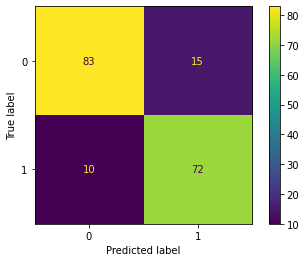

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels= None)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(include_values= True, cmap='viridis')

plt.show()